In [1]:
import pandas as pd
pd.options.display.max_columns=50
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool
from tqdm.notebook import tqdm

In [2]:
rez_path='/mnt/Production/Расчёт ГЭС/2021_05_27'

In [3]:
ges_vir=pd.read_excel('./data/ГЭСы с 1981.xlsx',skiprows=0,sheet_name=0,header=[0])
ges_vir['Год'] = ges_vir['Год'].fillna(method='ffill', axis=0)
ges_vir=ges_vir.dropna(subset=['Месяц'])

mes={'май':5,
'июнь':6,
'июль':7,
'август':8,
'сентябрь':9,
'октябрь':10,
'ноябрь':11,
'декабрь':12,
'январь':1,
'февраль':2,
'март':3,
'апрель':4}
ges_vir=ges_vir.replace(mes)
ges_vir['Месяц']=ges_vir['Месяц'].astype(int)
ges_vir['Год']=ges_vir['Год'].astype(int)


ges_vir.index=pd.to_datetime(ges_vir['Год'].astype(str)+'-'+ges_vir['Месяц'].astype(str)+'-01')
ges_vir=ges_vir.drop((['Год','Месяц']), axis=1)
ges_vir

,Братская ГЭС,Иркутская ГЭС,Красноярская ГЭС,Майнская ГЭС,Мамаканская ГЭС,Новосибирская ГЭС,Саяно-Шушенская ГЭС,Усть-Илимская ГЭС
1981-01-01,1852.000000,274.0000,0.000000,NaN,NaN,64.000,549.317000,1861.00
1981-02-01,1458.000000,254.0000,0.000000,NaN,NaN,56.000,397.648000,1593.00
1981-03-01,1304.000000,271.0000,0.000000,NaN,NaN,66.000,279.305000,1494.00
1981-04-01,1553.000000,238.0000,0.000000,NaN,NaN,134.000,232.001000,1164.00
1981-05-01,1383.000000,257.0000,0.000000,NaN,NaN,242.000,176.428000,1734.00
...,...,...,...,...,...,...,...,...
2020-11-01,2051.500000,419.5744,2196.998895,97.242,18.156,145.778,2083.151618,1772.10
2020-12-01,2113.500000,401.5270,1734.373716,87.980,12.876,89.508,1661.070000,1832.50
2021-01-01,2404.400000,385.0800,1541.760000,102.188,10.728,83.225,1464.575000,2090.70
2021-02-01,2182.048932,288.6240,1389.660000,86.471,7.152,89.471,1650.239193,1949.15


In [4]:
GES=pd.read_excel('./data/matrix.xlsx',skiprows=3,sheet_name=1,header=[0,1])
GES[[('Unnamed: 0_level_0','Год'), ('Unnamed: 1_level_0','N месяца')]] = GES[[('Unnamed: 0_level_0','Год'), ('Unnamed: 1_level_0','N месяца')]].fillna(method='ffill', axis=0).astype(int)
GES['data_g']=GES[('Unnamed: 0_level_0','Год')].astype(int)
GES['data_m']=GES[('Unnamed: 1_level_0','N месяца')].astype(int)
GES['data']=pd.to_datetime(GES['data_g'].astype(str)+'-'+GES['data_m'].astype(str) +'-01')
GES=GES.set_index('data')
GES=GES.drop(([ ('Unnamed: 0_level_0','Год'), ('Unnamed: 1_level_0','N месяца'),'data_g','data_m']), axis=1)
GES=GES.fillna(0)

cz='Сибирь'
GES=GES[cz]

GES=GES/1000
GES.head(3)

,Богучанская ГЭС,Братская ГЭС,Иркутская ГЭС,Красноярская ГЭС,Майнская ГЭС,Мамаканская ГЭС,Новосибирская ГЭС,Саяно-Шушенская ГЭС,Усть-Илимская ГЭС
data,,,,,,,,,
2007-01-01,0.0,2196.020,306.768,1392.65,154.100,12.288,89.52,1826.8,1895.9
2007-02-01,0.0,2113.641,296.814,1313.09,117.313,8.280,91.68,1534.1,1713.8
2007-03-01,0.0,2247.911,331.881,1688.29,133.300,8.988,105.81,1921.1,1891.6


<AxesSubplot:xlabel='data'>

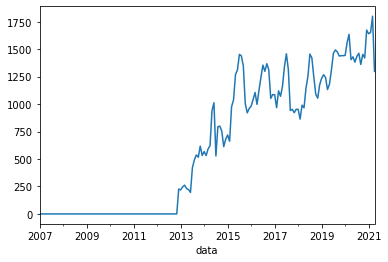

In [5]:
GES['Богучанская ГЭС'].plot()

In [6]:
#bogu=GES[['Богучанская ГЭС','Иркутская ГЭС','Братская ГЭС','Усть-Илимская ГЭС']][GES.index>='2015.06']
bogu=GES[['Богучанская ГЭС','Усть-Илимская ГЭС']][GES.index>='2015.06']

import numpy as np
from sklearn.linear_model import LinearRegression
model_bog = LinearRegression()

X=bogu.drop(columns=['Богучанская ГЭС'])
y=bogu['Богучанская ГЭС']

model_bog.fit(X.values, y.values)
r_sq = model_bog.score(X.values, y.values)
print('coefficient of determination:', r_sq)
print('slope:', model_bog.coef_,' intercept:', model_bog.intercept_)

coefficient of determination: 0.945692871319363
slope: [0.79265269]  intercept: 73.45032350247993


In [7]:
X

,Усть-Илимская ГЭС
data,
2015-06-01,1463.02
2015-07-01,1588.36
2015-08-01,1645.42
2015-09-01,1475.89
2015-10-01,1276.50
...,...
2020-12-01,2030.50
2021-01-01,2090.70
2021-02-01,1949.15


In [8]:
#bogu=GES[['Богучанская ГЭС','Иркутская ГЭС','Братская ГЭС','Усть-Илимская ГЭС']][GES.index>='2015.06']
mays=GES[['Саяно-Шушенская ГЭС','Майнская ГЭС']][GES.index>='2015.06']

import numpy as np
from sklearn.linear_model import LinearRegression
model_may = LinearRegression()

X=mays.drop(columns=['Майнская ГЭС'])
y=mays['Майнская ГЭС']

model_may.fit(X.values, y.values)
r_sq = model_may.score(X.values, y.values)
print('coefficient of determination:', r_sq)
print('slope:', model_may.coef_,' intercept:', model_may.intercept_)

coefficient of determination: 0.31204585194328327
slope: [0.01986338]  intercept: 71.6543666383283


In [9]:
X

,Саяно-Шушенская ГЭС
data,
2015-06-01,1921.167000
2015-07-01,1283.880000
2015-08-01,1316.580000
2015-09-01,1131.850000
2015-10-01,2266.950000
...,...
2020-12-01,1805.070000
2021-01-01,1464.575000
2021-02-01,1650.239193


In [10]:
nov=GES['Новосибирская ГЭС'].groupby('2021-'+GES.index.month.astype(str).str.zfill(2)+'-'+GES.index.day.astype(str).str.zfill(2)).mean()
nov

data
2021-01-01     86.001933
2021-02-01     84.323067
2021-03-01    104.711133
2021-04-01    172.759633
2021-05-01    266.131214
2021-06-01    278.574651
2021-07-01    283.155429
2021-08-01    216.806433
2021-09-01    166.877500
2021-10-01    152.629714
2021-11-01    130.570071
2021-12-01     90.181071
Name: Новосибирская ГЭС, dtype: float64

In [11]:
#mam=GES['Мамаканская ГЭС'].groupby('2021-'+GES.index.month.astype(str).str.zfill(2)+'-'+GES.index.day.astype(str).str.zfill(2)).mean()

mam=ges_vir['Мамаканская ГЭС'].groupby('2021-'+ges_vir.index.month.astype(str).str.zfill(2)+'-'+ges_vir.index.day.astype(str).str.zfill(2)).mean()

mam

2021-01-01     9.501993
2021-02-01     6.525113
2021-03-01     8.002633
2021-04-01    11.821286
2021-05-01    38.947597
2021-06-01    60.074759
2021-07-01    60.261910
2021-08-01    57.307968
2021-09-01    51.558806
2021-10-01    35.261679
2021-11-01    16.254269
2021-12-01    13.000750
Name: Мамаканская ГЭС, dtype: float64

In [12]:
pred=pd.read_excel('./Результат.xlsx',skiprows=0,sheet_name=0,header=[0], index_col=0)
pred

,Саяно-Шушенская ГЭС,Красноярская ГЭС,Иркутская ГЭС,Братская ГЭС,Усть-Илимская ГЭС,sum,enisey,angara
2021-01-01,1777.023890,1541.626998,385.060879,2403.571859,2090.008772,8082.112344,3358.172257,4878.484404
2021-02-01,1777.023890,1389.790122,288.680445,2182.139166,1949.379635,7643.112302,3276.730408,4419.979402
2021-03-01,1777.023890,1744.025910,344.344991,2155.419997,1960.008429,7895.917836,3806.492664,4425.424625
2021-04-01,1777.023890,1808.605463,347.574731,2078.011390,1882.293111,7658.442043,3643.706434,4332.503032
2021-05-01,2029.932809,1796.469885,322.942048,1939.877465,1691.272871,8283.366863,4493.241458,3890.655199
2021-06-01,2035.520507,1791.085650,310.733649,1785.389504,1590.867045,8223.585222,4220.477500,3691.004979
2021-07-01,2113.673729,1892.169927,322.081818,1819.352812,1656.436931,8545.577450,4451.008716,3782.540170
2021-08-01,2131.125041,1883.987549,350.663405,1883.638513,1771.279666,8638.534494,4171.230018,3960.204987
2021-09-01,2381.524493,1955.014477,380.579263,1899.843670,1775.992054,8811.590924,4849.169196,4006.276425
2021-10-01,2095.480166,1966.240263,355.261449,1846.321264,1712.252210,8497.040375,4492.786423,3909.322089


In [13]:
pred['Майнская ГЭС']= model_may.predict(pred['Саяно-Шушенская ГЭС'].values.reshape(-1,1))
pred['Майнская ГЭС']

2021-01-01    106.952060
2021-02-01    106.952060
2021-03-01    106.952060
2021-04-01    106.952060
2021-05-01    111.975685
2021-06-01    112.086676
2021-07-01    113.639063
2021-08-01    113.985705
2021-09-01    118.959483
2021-10-01    113.277677
2021-11-01    108.519812
2021-12-01    106.940580
2022-01-01    108.695725
2022-02-01    105.889130
2022-03-01    108.617968
2022-04-01    106.443619
2022-05-01    108.347094
2022-06-01    109.786593
2022-07-01    111.660117
2022-08-01    121.463435
2022-09-01    120.472560
2022-10-01    116.186671
2022-11-01    109.853353
2022-12-01    109.673350
2023-01-01    113.620342
2023-02-01    109.094356
2023-03-01    108.820576
2023-04-01    109.673350
2023-05-01    110.773426
2023-06-01    120.472560
2023-07-01    120.801676
2023-08-01    122.579448
2023-09-01    122.579448
2023-10-01    122.579448
2023-11-01    122.579448
2023-12-01    115.524912
2024-01-01    121.003994
2024-02-01    120.801676
2024-03-01    120.801676
2024-04-01    122.579448


In [14]:
pred['Богучанская ГЭС']= model_bog.predict(pred['Усть-Илимская ГЭС'].values.reshape(-1,1))
pred['Богучанская ГЭС']

2021-01-01    1730.101392
2021-02-01    1618.631328
2021-03-01    1627.056271
2021-04-01    1565.455015
2021-05-01    1414.042308
2021-06-01    1334.455361
2021-07-01    1386.429507
2021-08-01    1477.459910
2021-09-01    1481.195197
2021-10-01    1430.671638
2021-11-01    1437.927888
2021-12-01    1409.507012
2022-01-01    1354.815051
2022-02-01    1293.696775
2022-03-01    1269.909235
2022-04-01    1222.849618
2022-05-01    1252.640509
2022-06-01    1375.672504
2022-07-01    1471.229923
2022-08-01    1512.106214
2022-09-01    1489.645395
2022-10-01    1496.315131
2022-11-01    1498.871345
2022-12-01    1497.809598
2023-01-01    1493.433837
2023-02-01    1489.686985
2023-03-01    1475.053258
2023-04-01    1471.209065
2023-05-01    1472.167381
2023-06-01    1465.201419
2023-07-01    1476.527692
2023-08-01    1488.094097
2023-09-01    1467.869338
2023-10-01    1492.983862
2023-11-01    1489.855335
2023-12-01    1470.786240
2024-01-01    1478.561692
2024-02-01    1471.926528
2024-03-01  

In [15]:
nov

data
2021-01-01     86.001933
2021-02-01     84.323067
2021-03-01    104.711133
2021-04-01    172.759633
2021-05-01    266.131214
2021-06-01    278.574651
2021-07-01    283.155429
2021-08-01    216.806433
2021-09-01    166.877500
2021-10-01    152.629714
2021-11-01    130.570071
2021-12-01     90.181071
Name: Новосибирская ГЭС, dtype: float64

In [16]:
pred.index=pred.index.astype(str)

In [17]:
pred=pd.concat([pred, nov], axis=1)
pred=pd.concat([pred, mam], axis=1)

In [18]:
pred=pred.dropna(axis=0)

In [19]:
pred

,Саяно-Шушенская ГЭС,Красноярская ГЭС,Иркутская ГЭС,Братская ГЭС,Усть-Илимская ГЭС,sum,enisey,angara,Майнская ГЭС,Богучанская ГЭС,Новосибирская ГЭС,Мамаканская ГЭС
2021-01-01,1777.023890,1541.626998,385.060879,2403.571859,2090.008772,8082.112344,3358.172257,4878.484404,106.952060,1730.101392,86.001933,9.501993
2021-02-01,1777.023890,1389.790122,288.680445,2182.139166,1949.379635,7643.112302,3276.730408,4419.979402,106.952060,1618.631328,84.323067,6.525113
2021-03-01,1777.023890,1744.025910,344.344991,2155.419997,1960.008429,7895.917836,3806.492664,4425.424625,106.952060,1627.056271,104.711133,8.002633
2021-04-01,1777.023890,1808.605463,347.574731,2078.011390,1882.293111,7658.442043,3643.706434,4332.503032,106.952060,1565.455015,172.759633,11.821286
2021-05-01,2029.932809,1796.469885,322.942048,1939.877465,1691.272871,8283.366863,4493.241458,3890.655199,111.975685,1414.042308,266.131214,38.947597
2021-06-01,2035.520507,1791.085650,310.733649,1785.389504,1590.867045,8223.585222,4220.477500,3691.004979,112.086676,1334.455361,278.574651,60.074759
2021-07-01,2113.673729,1892.169927,322.081818,1819.352812,1656.436931,8545.577450,4451.008716,3782.540170,113.639063,1386.429507,283.155429,60.261910
2021-08-01,2131.125041,1883.987549,350.663405,1883.638513,1771.279666,8638.534494,4171.230018,3960.204987,113.985705,1477.459910,216.806433,57.307968
2021-09-01,2381.524493,1955.014477,380.579263,1899.843670,1775.992054,8811.590924,4849.169196,4006.276425,118.959483,1481.195197,166.877500,51.558806
2021-10-01,2095.480166,1966.240263,355.261449,1846.321264,1712.252210,8497.040375,4492.786423,3909.322089,113.277677,1430.671638,152.629714,35.261679


In [26]:
pred.to_excel('Результат все станции.xlsx')

pred['Пробел']=''
pred[['Саяно-Шушенская ГЭС','Майнская ГЭС','Красноярская ГЭС','Пробел','Иркутская ГЭС','Братская ГЭС',
'Усть-Илимская ГЭС','Богучанская ГЭС','Новосибирская ГЭС','Мамаканская ГЭС']].to_excel(rez_path+'/Результат все станции.xlsx')


In [ ]:
'Саяно-Шушенская ГЭС','Майнская ГЭС','Красноярская ГЭС','Пробел','Иркутская ГЭС','Братская ГЭС',
'Усть-Илимская ГЭС','Богучанская ГЭС','Новосибирская ГЭС','Мамаканская ГЭС'


<AxesSubplot:>

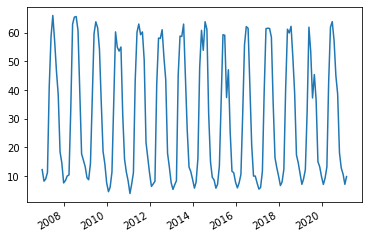

In [21]:
ges_vir['Мамаканская ГЭС'].plot()

<AxesSubplot:>

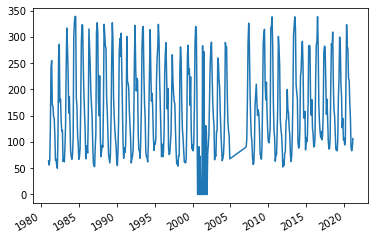

In [22]:
ges_vir['Новосибирская ГЭС'].plot()

In [23]:
SM=ges_vir.groupby('2021-'+ges_vir.index.month.astype(str).str.zfill(2)+'-'+ges_vir.index.day.astype(str).str.zfill(2)).mean()

SM.to_excel('Среднее многолетнее.xlsx')